Day=1, Predicted=1365.773575, Expected=1544.000000
Day=2, Predicted=1325.546770, Expected=1536.000000
Day=3, Predicted=1308.369946, Expected=1549.000000
Day=4, Predicted=1339.962451, Expected=1670.000000
Day=5, Predicted=1393.842573, Expected=1803.000000
Day=6, Predicted=1344.926766, Expected=1733.000000
Day=7, Predicted=1360.836974, Expected=1777.000000
Day=8, Predicted=1419.691916, Expected=1827.000000
Day=9, Predicted=1573.551001, Expected=1831.000000
Day=10, Predicted=1527.028641, Expected=1518.000000
Day=11, Predicted=1686.591170, Expected=1434.000000
Day=12, Predicted=1725.456999, Expected=1536.000000
Day=13, Predicted=1431.774451, Expected=1613.000000
Day=14, Predicted=1452.977819, Expected=1557.000000
Day=15, Predicted=1399.213647, Expected=1747.000000
Day=16, Predicted=1384.085101, Expected=1565.000000
Day=17, Predicted=1356.923071, Expected=1514.000000
Day=18, Predicted=1377.310516, Expected=1561.000000
Day=19, Predicted=1309.951188, Expected=1551.000000
Day=20, Predicted=130

Day=225, Predicted=1601.987233, Expected=1480.000000
Day=226, Predicted=1604.363370, Expected=1692.000000
Day=227, Predicted=1584.578678, Expected=1650.000000
Day=228, Predicted=1587.564575, Expected=1700.000000
Day=229, Predicted=1582.728909, Expected=1714.000000
Day=230, Predicted=1597.867948, Expected=1729.000000
Day=231, Predicted=1511.969873, Expected=1732.000000
Day=232, Predicted=1539.793183, Expected=1700.000000
Day=233, Predicted=1555.264904, Expected=1701.000000
Day=234, Predicted=1564.306604, Expected=1628.000000
Day=235, Predicted=1526.503861, Expected=1698.000000
Day=236, Predicted=1532.013336, Expected=1700.000000
Day=237, Predicted=1551.817156, Expected=1680.000000
Day=238, Predicted=1522.936109, Expected=1708.000000
Day=239, Predicted=1573.239371, Expected=1682.000000
Day=240, Predicted=1594.072824, Expected=1680.000000
Day=241, Predicted=1566.777038, Expected=1608.000000
Day=242, Predicted=1610.772708, Expected=1688.000000
Day=243, Predicted=1630.391962, Expected=1650.

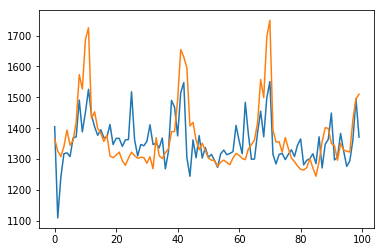

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('bajri1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-1096], supervised_values[1096:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 30, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[1097:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[:100])
pyplot.plot(predictions[:100])
pyplot.show()

Test RMSE: 143.834


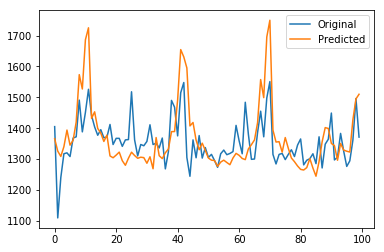

In [5]:
rmse = sqrt(mean_squared_error(raw_values[1097:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[:100], label="Original")
pyplot.plot(predictions[:100], label="Predicted")
pyplot.legend()
pyplot.show()